# A Simple Framework for Contrastive Learning of Visual Representations
* In this notebook, we will be implementing the code for SimCLR.
* We have done the augmentation, as per the original code provided the researchers behind this paper.
* [Reference](http://proceedings.mlr.press/v119/chen20j.html) for the paper

# Importing Packages and Boilerplate code

In [33]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [56]:
# Basic Imports 
import math
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import *

# Plotting libraries
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Utilities
import datetime
import os,sys
import tempfile
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append("/kaggle/input/helper-files")
import random 
import gc
import time
import functools
from imutils import paths
from tqdm import tqdm
from typing import Callable

# Random seed fixation for experiment result repitition
tf.random.set_seed(10)
np.random.seed(10)

print("Tensorflow version : ",tf.__version__)
from shutil import copyfile
from tabulate import tabulate
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import tensorflow.keras.layers as tfl

Tensorflow version :  2.6.2


In [35]:
# Setting the seeds
SEED = 0
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [36]:
# Making sure that Tensorflow is able to detect the GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Importing Train/Test Sets

In [37]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Defining a function to list the memory consumed
# Only outputs variables taking at least 1MB space
def list_storage(inp_dir):
    # Get a sorted list of the objects and their sizes
    vars_defined = [x for x in inp_dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    sto = sorted([(x, sys.getsizeof(globals().get(x))) for x in vars_defined], key=lambda x: x[1], reverse=True)
    sto = [(x[0], str(round((x[1] / 2**20), 2)) + ' MB') for x in sto if x[1] >= 2**20]
    print(tabulate(sto, headers = ['Variable', 'Storage (in MB)']))

# In order to use this function, use the below line of code
# list_storage(dir())

In [38]:
# Importing the Labelled Dataset
df_train = pd.read_csv("../input/cifar10/train_lab_x.csv")
y_train = pd.read_csv("../input/cifar10/train_lab_y.csv")

# Importing the Test Dataset
df_test = pd.read_csv("../input/cifar10/test_x.csv")
y_test = pd.read_csv("../input/cifar10/test_y.csv")

# Basic Augmentation Pipeline

(40006, 3072) (40006, 1)
(40006, 3, 32, 32)
[0]
(40006, 32, 32, 3) (40006, 10)
(10000, 3072) (10000, 1)
(10000, 3, 32, 32)
(10000, 32, 32, 3) (10000, 10)
Tensorflow version :  2.6.2


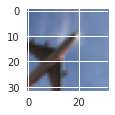

In [39]:
df_train = np.array(df_train)
y_train = np.array(y_train)
print(df_train.shape, y_train.shape)

# Reshaping the dataset
df_train = np.reshape(df_train, (-1, 3, 32, 32))
print(df_train.shape)

# Visualizing a single image
ind = 11
example = df_train[ind, : , : , : ]
example = example.transpose((1, 2, 0))
plt.figure(figsize=(1.5, 1.5))
plt.imshow(example)
print(y_train[ind])

# Creating a random permutation
perm = np.random.permutation(df_train.shape[0])

# Shuffling the training dataset
df_train = df_train[perm, : , : , : ]
y_train = y_train[perm]

# Reshaping, rescaling and one-hot encoding
df_train = np.transpose(np.array(df_train), (0, 2, 3, 1))
df_train = df_train / 255
y_train_oh = tf.one_hot(np.ravel(y_train), depth = 10)

print(df_train.shape, y_train_oh.shape)

df_test = np.array(df_test)
y_test = np.array(y_test)
print(df_test.shape, y_test.shape)

# Reshaping the dataset
df_test = np.reshape(df_test, (-1, 3, 32, 32))
print(df_test.shape)

# Reshaping, rescaling and one-hot encoding
df_test = np.transpose(np.array(df_test), (0, 2, 3, 1))
df_test = df_test / 255
y_test_oh = tf.one_hot(np.ravel(y_test), depth = 10)
print(df_test.shape, y_test_oh.shape)

# Random seed fixation for experiment result repitition
tf.random.set_seed(10)
np.random.seed(10)

print("Tensorflow version : ",tf.__version__)

# In-order run function decorators in tf2.0
tf.config.run_functions_eagerly(False)

## Helper Code

In [40]:
# Image training properties 
IMG_H, IMG_W = (32, 32)

# How powerful you want the colour augmentations to be
color_jitter_strength = 0.3

# Minimum crop area you want
minimum_object_coverage = 0.7

# Range of crop area
area_range = (minimum_object_coverage, 1.0)
BATCH_SIZE = 32

# Model Building
## Model Helper Functions

In [41]:
# Helper functions
@tf.function
def input_image_loader(image):
    image_norm = tf.image.convert_image_dtype(image, tf.float32)
    
    # The IMG_H & IMG_W are constants that will be read only once during graph tracing step
    image_norm = tf.image.resize(image_norm, size=[IMG_H, IMG_W])
    

    aug_image_1 = preprocess_image(image = image_norm, 
                                    height = IMG_H, 
                                    width  = IMG_W, 
                                    cjs = color_jitter_strength,
                                    m_obj_cov = minimum_object_coverage,
                                    a_range = area_range)

    aug_image_2 = preprocess_image(image = image_norm, 
                                    height = IMG_H, 
                                    width  = IMG_W, 
                                    cjs = color_jitter_strength,
                                    m_obj_cov = minimum_object_coverage,
                                    a_range = area_range)
    # view 1 & view 2
    return aug_image_1, aug_image_2

In [42]:
# adding l2 reg
def add_regularization(model, regularizer = tf.keras.regularizers.l2(0.0001)):
    """
    Helper function to add l2 regularisation to each layer of a either a preTrained or 
    randomly initialised built in model
    Arguments:
        model : (keras.model) input model 
        regularizer : ( tf.keras.regularizers.l2) object from keras that defines a l2 regularizer
    Returns:
        model : all layers contain the "regularizer" object & incase we pass a pretrained model then the 
                original weights are preserved
    """

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

# Architecture utils
# def get_simclr(hidden_1, 
#                hidden_2, 
#                l2_penalty = 10e-6):
def simclr_model(input_shape):
    """
    Main function to define the entire network backbone to train
    Arguments:
        hidden_1-2 : (int) variable to define number of neurons in the projection head dense layer
        l2_penalty : (float) to define the amount of l2 penalty applied to each layer's weights
    Returns:
        final_model : (tf.keras.Model) final model that will be trained 
    """
    
#     # encoder network
#     base_model = tf.keras.applications.ResNet50V2(include_top = False, 
#                                                   weights = None, 
#                                                   input_shape = (IMG_H, IMG_W, 3))
    
#     # defining l2 regularization
#     regularizer = tf.keras.regularizers.l2(l2_penalty)
#     reg_base_model = add_regularization(base_model,regularizer)
#     reg_base_model.trainable = True

#     # Joining the entire pipeline using functional API
    inputs = Input((IMG_H, IMG_W, 3))
#     h = reg_base_model(inputs, training=True)
#     h = GlobalAveragePooling2D()(h)
    
#     # Non linear projection layer to improve the quality of embeddings being produced
#     projection_1 = Dense(hidden_1, kernel_regularizer = regularizer)(h)
#     projection_1 = tf.keras.layers.BatchNormalization()(projection_1)
#     projection_1 = Activation("relu")(projection_1)
#     projection_2 = Dense(hidden_2, kernel_regularizer = regularizer)(projection_1)
#     projection_2 = tf.keras.layers.BatchNormalization()(projection_2)
#     projection_2 = Activation("relu")(projection_2)

    input_img = tf.keras.Input(shape = input_shape)
    
    Z1 = tfl.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(input_img)
    B1 = tfl.BatchNormalization(axis=-1)(Z1)
    Z2 = tfl.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(B1)
    B2 = tfl.BatchNormalization(axis=-1)(Z2)
    P1 = tfl.MaxPool2D(pool_size=2, strides=2, padding='valid')(B2)
    D1 = tfl.Dropout(0.25)(P1)
    # (16, 16, 16)
    
    Z3 = tfl.Conv2D(32, kernel_size=2, strides=1, padding='valid', activation='relu')(D1)
    B3 = tfl.BatchNormalization(axis=-1)(Z3)
    Z4 = tfl.Conv2D(32, kernel_size=2, strides=1, padding='valid', activation='relu')(B3)
    B4 = tfl.BatchNormalization(axis=-1)(Z4)
    P2 = tfl.MaxPool2D(pool_size=2, strides=2, padding='valid')(B4)
    D2 = tfl.Dropout(0.25)(P2)
    # (7, 7, 32)
    
    F1 = tfl.Flatten()(D2)
    Den1 = tfl.Dense(256, activation='relu')(F1)
    Drop1 = tfl.Dropout(0.25)(Den1)
    Den2 = tfl.Dense(64, activation='relu')(Drop1)
    Drop2 = tfl.Dropout(0.25)(Den2)
    outputs = tfl.Dense(10, activation='softmax')(Drop2)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    return model

    # Final Model
    final_model = Model(inputs, outputs)
    return final_model

## Train Step Functions

In [43]:
# Mask to remove positive examples from the batch of negative samples
# negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [44]:
@tf.function
def train_step(xis, 
               xjs, 
               model, 
               optimizer, 
               criterion, 
               temperature):

    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors : onto a unit hypersphere
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)
          
        # calculating over set of all positive pairs ( computing all numerators of softmax)
        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))

        # temperature scaling
        l_pos /= temperature
        
        # make the batch dimension 2*n
        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0
        for positives in [zis, zjs]:
            # computing similarity with a data point & all the possible negatives
            l_neg = sim_func_dim2(positives, negatives)
            
            # since each data point is its own class
            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)
            
            # using the negative mask to remove itself & its positve counterpart to compute negative sim
            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))

            # temperature scaling
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred = logits, y_true = labels)

        # since for every data point including its augmentation we compute the loss thus divide by 2*BatchSize
        loss = loss / (2 * BATCH_SIZE)
    
    # Compute & apply the gradients on traininable paramters of the model
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # updated model along with gradients so that we can visualise them on tensorboard.
    return loss, gradients

In [45]:
def train_simclr(model, 
                 train_dataset, 
                 optimizer, 
                 criterion,
                 temperature=0.1, 
                 epochs=100,
                 num_train_samples_viz = 5,
                 num_test_samples_viz = 2):
    
    """
      Training the model function
    """
    
 
    print("Starting training procedure .... : ")
    print("Number of steps per epoch : ",len(train_dataset))
    
    # To measure per epoch time taken
    t_start = time.time()
    
    # Visualisation lists
    lr_epoch = []
    epoch_wise_loss = []

    for epoch in range(0, epochs):
        
        # Reset loss collection each step
        step_wise_loss = []

        # Number of grad descent steps in 1 epoch
        num_train_steps = len(train_dataset) 

        # Picking up random batches & taking first image for input check
        random_batches_train = random.sample(range(len(train_dataset)),num_train_samples_viz)
        cnt = 0

        # Arrays for tensorboard visualisation
        random_collection_train_sample_1 = []
        random_collection_train_sample_2 = []
        gradArray = None
        loss = None 

        # Training loop
        for image_batch in tqdm(train_dataset):

            # Fetching both views for input
            a = image_batch[0]
            b = image_batch[1]

            # Train one batch
            loss, gradArray = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

            # Check whether to take image from this batch or not
            if cnt in random_batches_train:
                random_collection_train_sample_1.append(image_batch[0][0])
                random_collection_train_sample_2.append(image_batch[1][0])
            cnt+=1
        
        # Average loss throughout the whole process
        if not len(epoch_wise_loss):
            epoch_wise_loss.append(np.mean(step_wise_loss))
        else:
            # Adding the mean of previous ones
            mean_value = (np.sum(step_wise_loss) + epoch_wise_loss[-1]*(epoch)*num_train_steps)/((epoch+1)*num_train_steps)
            epoch_wise_loss.append(mean_value)
        
        # Printing the loss progression
        print("\n epoch: {} | train loss: {:.8f} | lr : {} | {:.4f} mins"
              .format(epoch + 1,epoch_wise_loss[-1],optimizer._decayed_lr(tf.float32).numpy(), (time.time()-t_start)/60.0))    
   
        # Appending the value of learning rate for warmup + cosine decay visualisation
        lr_epoch.append(optimizer._decayed_lr(tf.float32).numpy())
        
        # Tensorfboard visualisations
        tf.summary.experimental.set_step(epoch)
        with train_summary_writer.as_default():
            tf.summary.scalar('LOSS', epoch_wise_loss[-1], step=epoch)
            tf.summary.scalar('LEARNING RATE PROGRESSION', lr_epoch[-1], step = epoch)
            tf.summary.image('VIEW 1', random_collection_train_sample_1, step=epoch)
            tf.summary.image('VIEW 2', random_collection_train_sample_2, step=epoch)

            # global variable defined later
            for name in layer_names:
                tf.summary.histogram(name+"_gradients",gradArray[layer_to_index[name]])
                
            for layer in model.layers:
                for tl in layer.trainable_weights:
                    if tl.name in layer_names:
                        tf.summary.histogram(tl.name+"_weights",tl.numpy())
        
        # saving models 
        print("Saving Base Model.....")
        
        # Saving the entire model for checkpointing reasons
        model.save("./" + modelNameStr + ".h5")

        # saving the state of optimizer
        np.save("./" + modelNameStr + "_optimizer.npy", optimizer.get_weights())

    
    return epoch_wise_loss, model

In [46]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self,
               initial_learning_rate: float,
               decay_schedule_fn: Callable,
               warmup_steps: int,
               power: float = 1.0,
               name: str = None,):
    
    super().__init__()
    self.initial_learning_rate = initial_learning_rate
    self.warmup_steps = warmup_steps
    self.power = power
    self.decay_schedule_fn = decay_schedule_fn
    self.name = name

  def __call__(self, step):
    with tf.name_scope(self.name or "WarmUp") as name:
        # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
        # learning rate will be `global_step/num_warmup_steps * init_lr`.
        global_step_float = tf.cast(step, tf.float32)
        warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
        warmup_percent_done = global_step_float / warmup_steps_float
        warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
        return tf.cond(
            global_step_float < warmup_steps_float,
            lambda: warmup_learning_rate,
            lambda: self.decay_schedule_fn(step - self.warmup_steps),
            name=name,
        )

  def get_config(self):
    return {
        "initial_learning_rate": self.initial_learning_rate,
        "decay_schedule_fn": self.decay_schedule_fn,
        "warmup_steps": self.warmup_steps,
        "power": self.power,
        "name": self.name,
    }

In [47]:
# Defining the loss function
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
# Number of epochs
tot_epochs = 5

# temperature in NTXent
loss_temp = 0.2

# Defining the SimCLR model
# Differentiating models via their hyper-parameter values
# simclr_2 = simclr_model((32, 32))


# optimiser decay schedule
decay_steps = (len(df_train))*tot_epochs
warmup_steps = (len(df_train))*10
initial_lr = 0.5e-3

# Cosine decay function
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate = initial_lr, 
                                                  decay_steps = decay_steps)
cosine_with_warmUp = WarmUp(initial_learning_rate = initial_lr,
                            decay_schedule_fn = lr_decayed_fn,
                            warmup_steps = warmup_steps)

print("Decay Steps : ",decay_steps)
optimizer = tf.keras.optimizers.Adam(cosine_with_warmUp)

Decay Steps :  200030


In [48]:
simclr = simclr_model((32, 32, 3))
simclr.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
simclr.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 16, 16)        0   

## Training SimCLR

In [49]:
# Composing the Train Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((df_train, y_train_oh)).batch(32)

In [50]:
num_epochs = [10, 20]
train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epochs in num_epochs:
    # Training the Model
    simclr = simclr_model((32, 32, 3))
    simclr.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    simclr.fit(train_dataset, epochs = epochs)
    
    # Predicting on the Train/Test Datasets
    preds_train = simclr.predict(df_train)
    preds_test = simclr.predict(df_test)

    # Finding the Predicted Classes
    cls_train = np.argmax(preds_train, axis = 1)
    cls_test = np.argmax(preds_test, axis = 1)
    
    # Finding the Train/Test set Loss
    train_loss.append(log_loss(y_train_oh, preds_train))
    test_loss.append(log_loss(y_test_oh, preds_test))
    train_acc.append(accuracy_score(y_train, cls_train))
    test_acc.append(accuracy_score(y_test, cls_test))
    
    print("For ", epochs, " Epochs:")
    print("Log-loss for Train Dataset = ", train_loss[-1])
    print("Log-loss for Test Dataset = ", test_loss[-1])
    print("Accuracy for Train Dataset = ", train_acc[-1])
    print("Accuracy for Test Dataset = ", test_acc[-1])
    print()

Epoch 1/10
1251/1251 [==============================] - 7s 5ms/step - loss: 1.7116 - accuracy: 0.3785
Epoch 2/10
1251/1251 [==============================] - 7s 5ms/step - loss: 1.3008 - accuracy: 0.5412
Epoch 3/10
1251/1251 [==============================] - 6s 5ms/step - loss: 1.1237 - accuracy: 0.6080
Epoch 4/10
1251/1251 [==============================] - 6s 5ms/step - loss: 1.0189 - accuracy: 0.6499
Epoch 5/10
1251/1251 [==============================] - 6s 5ms/step - loss: 0.9364 - accuracy: 0.6765
Epoch 6/10
1251/1251 [==============================] - 7s 6ms/step - loss: 0.8787 - accuracy: 0.6990
Epoch 7/10
1251/1251 [==============================] - 6s 5ms/step - loss: 0.8349 - accuracy: 0.7098
Epoch 8/10
1251/1251 [==============================] - 6s 5ms/step - loss: 0.7949 - accuracy: 0.7275
Epoch 9/10
1251/1251 [==============================] - 6s 5ms/step - loss: 0.7559 - accuracy: 0.7365
Epoch 10/10
1251/1251 [==============================] - 7s 6ms/step - loss: 0.726

In [51]:
# Training the Model with the best hyper-parameter settings
ind = np.argmax(test_acc)
best_num_epochs = num_epochs[ind]
simclr = simclr_model((32, 32, 3))
simclr.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
simclr.fit(train_dataset, epochs = best_num_epochs)

# Saving the model along with it's weights
simclr.save('simclr_model.h5')

# Predicting on the Train/Test Datasets
preds_train = simclr.predict(df_train)
preds_test = simclr.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

Epoch 1/20
1251/1251 [==============================] - 7s 5ms/step - loss: 1.7422 - accuracy: 0.3701
Epoch 2/20
1251/1251 [==============================] - 7s 5ms/step - loss: 1.2988 - accuracy: 0.5387
Epoch 3/20
1251/1251 [==============================] - 6s 5ms/step - loss: 1.1090 - accuracy: 0.6137
Epoch 4/20
1251/1251 [==============================] - 6s 5ms/step - loss: 1.0028 - accuracy: 0.6520
Epoch 5/20
1251/1251 [==============================] - 6s 5ms/step - loss: 0.9253 - accuracy: 0.6827
Epoch 6/20
1251/1251 [==============================] - 7s 6ms/step - loss: 0.8691 - accuracy: 0.6980
Epoch 7/20
1251/1251 [==============================] - 6s 5ms/step - loss: 0.8148 - accuracy: 0.7183
Epoch 8/20
1251/1251 [==============================] - 6s 5ms/step - loss: 0.7824 - accuracy: 0.7303
Epoch 9/20
1251/1251 [==============================] - 6s 5ms/step - loss: 0.7446 - accuracy: 0.7393
Epoch 10/20
1251/1251 [==============================] - 6s 5ms/step - loss: 0.714

# Final Predictions

In [52]:
# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_train_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Accuracy for Train Dataset = ", accuracy_score(y_train, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.27172134258553937
Log-loss for Test Dataset =  0.7683091839501851
Accuracy for Train Dataset =  0.9085387191921211
Accuracy for Test Dataset =  0.7573
